<a href="https://colab.research.google.com/github/gh0st-kid/TimeSerieseProject/blob/main/TS_model_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score,
                             accuracy_score, classification_report,
                             confusion_matrix)
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss
import warnings
import logging

In [15]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Statsmodels версия: {sm.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.1.4
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Statsmodels версия: 0.14.3
Библиотеки успешно импортированы.


In [5]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в формат даты и установлен в качестве индекса.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по году.
  """
  df = pd.read_csv(file_path, delimiter=';')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)
  numeric_columns = df.columns[1:]
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('year', inplace=True)
  df.set_index('year', inplace=True)
  return df

df = load_and_prepare_data('/content/Data_new.csv')

In [6]:
df.head()

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
year,,,,,,,,,,,,,,,,,,,,,
2000-12-31,18014.45,6684.28,5850.76,2603.97,14242.84,5720.02,7933.75,4020.35,1516.38,710.35,...,1124.00,628.32,3231.0,2269.0,1592.0,1130.0,1726.0,2744.0,1933.0,2498.0
2001-12-31,18209.86,6788.93,5846.68,2653.35,14225.29,5642.28,7817.38,3939.14,1165.34,556.96,...,929.68,521.56,4300.0,3084.0,2165.0,1441.0,2319.0,3820.0,2576.0,3304.0
2002-12-31,18596.99,6911.31,6071.07,2762.83,14457.40,5733.71,8054.44,4071.13,1000.25,460.45,...,868.63,435.51,5436.0,4010.0,2898.0,1922.0,3035.0,4791.0,3373.0,4391.0
2003-12-31,18609.92,6873.34,5816.19,2765.72,14280.29,5974.66,7972.59,4046.69,1002.11,516.25,...,972.79,455.21,7211.0,5403.0,3747.0,2532.0,3917.0,6110.0,4351.0,5788.0
2004-12-31,18912.54,6970.38,6156.19,2769.92,14378.12,5938.58,8179.20,4013.68,930.45,443.38,...,853.29,442.81,8992.0,6938.0,4565.0,3466.0,4787.0,7413.0,5267.0,7047.0


In [7]:
def split_train_test_by_ratio(series, train_size=0.7):
    """
    Делит временной ряд на обучающую и тестовую выборки по соотношению.

    Аргументы:
    series : pandas.Series
        Временной ряд, который нужно разделить.
    train_size : float, optional
        Доля обучающей выборки (по умолчанию 0.8).

    Возвращает:
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    """
    split_index = int(len(series) * train_size)
    train = series[:split_index]
    test = series[split_index:]
    return train, test

In [8]:
def train_arima_model(train, p, d, q):
    """
    Обучает модель ARIMA с заданными параметрами p, d, q.

    Аргументы:
    train : pandas.Series
        Обучающая выборка временного ряда.
    p : int
        Параметр p модели ARIMA.
    d : int
        Параметр d модели ARIMA.
    q : int
        Параметр q модели ARIMA.

    Возвращает:
    model : ARIMA
        Обученная модель ARIMA.
    """
    model = ARIMA(train, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

In [9]:
def forecast_arima(series, p, d, q, future_periods=3):
    """
    Предсказывает значения временного ряда с помощью модели ARIMA.

    Аргументы:
    series: pandas.Series
        Временной ряд.
    p, d, q: int
        Параметры модели ARIMA.
    future_periods: int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    forecast: pandas.Series
        Прогноз на тестовый период.
    future_forecast: pandas.Series
        Прогноз на будущие периоды.
    conf_int: pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    """

    # Разделение данных
    train, test = split_train_test_by_ratio(series)

    # Установка частоты индекса
    if test.index.freq is None:
        test = test.asfreq('Y')  # Установка годовой частоты с концом года в декабре

    # Обучение модели
    model = train_arima_model(train, p, d, q)

    # Прогноз на тестовый период
    forecast = model.forecast(steps=len(test))
    conf_int = model.get_forecast(steps=len(test)).conf_int()

    # Обновляем модель на основе всего ряда, включая тестовый период
    full_model = train_arima_model(series, p, d, q)

    # Прогноз на будущие периоды
    future_forecast = full_model.forecast(steps=future_periods)
    future_conf_int = full_model.get_forecast(steps=future_periods).conf_int(alpha=0.05)

    # Создание индекса для будущего прогноза
    future_dates = pd.date_range(start=test.index[-1], periods=future_periods + 1, freq='Y')[1:]
    future_forecast = pd.Series(future_forecast, index=future_dates)

    return forecast, future_forecast, conf_int, future_conf_int

In [10]:
def evaluate_forecast(test, forecast):
    """
    Оценивает прогноз с использованием метрик RMSE, MAE, MAPE.

    Аргументы:
    test : pandas.Series
        Реальные значения из тестовой выборки.
    forecast : pandas.Series
        Прогнозируемые значения.

    Возвращает:
    rmse : float
        Корень из средней квадратичной ошибки.
    mae : float
        Средняя абсолютная ошибка.
    mape : float
        Средняя абсолютная процентная ошибка.
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    return rmse, mae, mape

In [11]:
def plot_forecast(series, train, test, forecast, conf_int, future_forecast, future_conf_int):
    """
    Визуализирует исходный ряд, обучающую выборку, прогноз на тестовом периоде и прогноз на будущие периоды.

    Аргументы:
    series : pandas.Series
        Исходный временной ряд.
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    forecast : pandas.Series
        Прогноз на тестовом периоде.
    conf_int : pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    future_forecast : pandas.Series
        Прогноз на будущие периоды.
    future_conf_int : pandas.DataFrame
        Доверительные интервалы для будущих прогнозов.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original Series')
    plt.plot(test.index, test, label='Test')
    plt.plot(forecast.index, forecast, label='Forecast')

    # Доверительные интервалы для тестового периода
    plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Прогноз на будущее
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast', linestyle='--')

    # Доверительные интервалы для будущих периодов
    plt.fill_between(future_forecast.index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ARIMA Model Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def arima_pipeline(series, p, d, q, train_size=0.8, future_periods=3):
    """
    Пайплайн для выполнения всех шагов ARIMA анализа, включая разделение данных, обучение модели,
    прогнозирование, оценку прогноза и визуализацию результатов.

    Аргументы:
    series : pandas.Series
        Временной ряд.
    p, d, q : int
        Параметры модели ARIMA.
    train_size : float, optional
        Доля обучающей выборки (по умолчанию 0.8).
    future_periods : int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    metrics : dict

        Метрики оценки модели (RMSE, MAE, MAPE).
    future_forecast : pandas.Series
        Прогнозы на будущие периоды.
    """
    # 1. Разделение данных
    train, test = split_train_test_by_ratio(series, train_size)

    # 2. Обучение модели ARIMA
    model = train_arima_model(train, p, d, q)

    # 3. Прогнозирование на тестовом периоде и на будущее
    forecast, future_forecast, conf_int, future_conf_int = forecast_arima(series, p, d, q, future_periods)

    # 4. Оценка прогноза
    rmse, mae, mape = evaluate_forecast(test, forecast)
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # 5. Визуализация результатов
    plot_forecast(series, train, test, forecast, conf_int, future_forecast, future_conf_int)

    return metrics, future_forecast

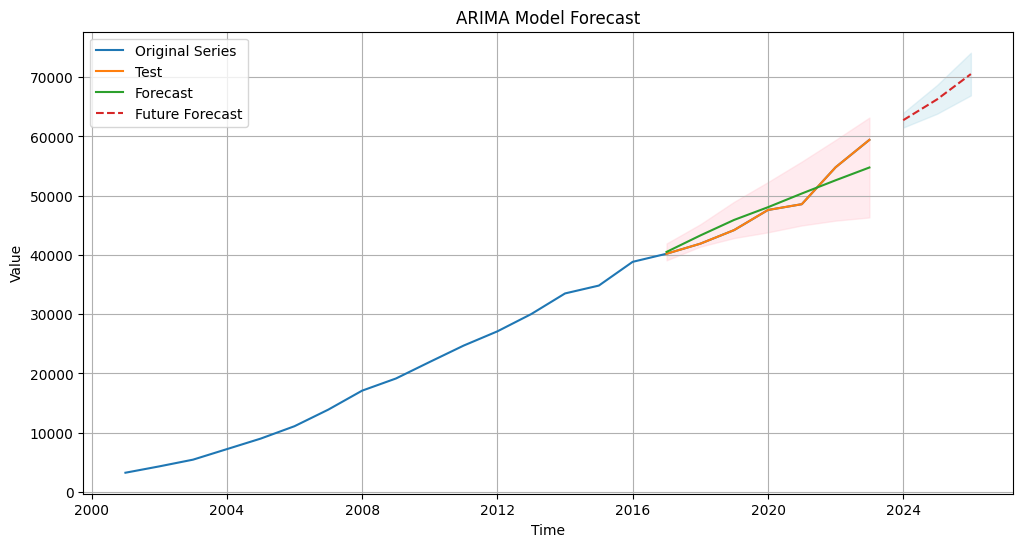

({'RMSE': 2237.339402996339,
  'MAE': 1791.9393723105645,
  'MAPE': 3.501993223999268},
 2023-12-31    62744.201253
 2024-12-31    66261.413341
 2025-12-31    70534.061161
 Freq: A-DEC, Name: predicted_mean, dtype: float64)

In [16]:
arima_pipeline(df['srd(cfo)'], p=1, d=1, q=5, train_size=0.7, future_periods=3)